<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-pytorch/blob/main/image_classification/fixed_feature_extractor_ant_vs_bee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# upload kaggle API key from you local machine
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shazzadraihan","key":"96c107c9376e84d48cd954b519ce7c9b"}'}

In [ ]:
# make a kaggle dir, copy the API key to it 
# and make sure the file is only readable by yourself (chmod 600)
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# use API command to download the dataset
!kaggle datasets download -d thedatasith/hymenoptera

 79% 36.0M/45.6M [00:00<00:00, 191MB/s]
100% 45.6M/45.6M [00:00<00:00, 185MB/s]


In [ ]:
# uncompress the dataset
!unzip -qq hymenoptera.zip

In [ ]:
# import required libraries
import torch
import torchvision

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# check if cuda in available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print("CUDA is not available")
else:
  print("CUDA is available")

device = torch.device("cuda") if train_on_gpu else torch.device("cpu")

CUDA is available


### Load and visualize the dataset

In [ ]:
# define training and validation data directories
data_dir = "/content/hymenoptera/"
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, 'val')

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# load and transform data using ImageFolder

data_transform = transforms.Compose([
          transforms.RandomResizedCrop(244), # Efficient B0 takes 244x244 images as input
          transforms.RandomHorizontalFlip(), # horizontally flip images (randomly)
          transforms.RandomRotation(10),     # rotate by 10 degree (randomly)
          transforms.ToTensor(), # convert to torch.FloatTensor
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize
          ])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform)

# print out some data stats
print("Number of training images: ", len(train_data))
print("Number of validation images: ", len(valid_data))

Number of training images:  244
Number of validation images:  153


In [ ]:
# define dataloader parameters

# number of subprocess to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 4

# prepare train and validation data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

# image classes in the dataset
classes = train_data.classes
print(classes)

['ants', 'bees']


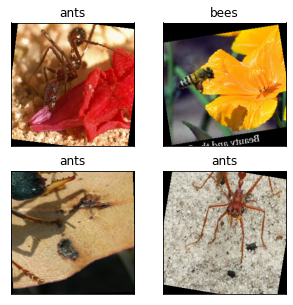

In [ ]:
# visualize a batch of training data

def imshow(img):
  # unnormalize
  img = np.transpose(img, (1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  img = np.clip(img, 0, 1)
  plt.imshow(img)

# obtain one batch on training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# convert images to numpy for display
images = images.numpy() 

# plot the images in the batch along with the corresponding labels
fig = plt.figure(figsize=(5,5))
# display 10 images
for ind in np.arange(4):
  ax = fig.add_subplot(2, 4/2, ind+1, xticks=[], yticks=[])
  imshow(images[ind])
  ax.set_title(classes[labels[ind]])

### Define a pre-trained model

In [ ]:
from torchvision import models

# load a pre-trained model
model = models.efficientnet_b0(pretrained=True)

# print out the model stracture
print(model)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [ ]:
print(model.classifier[1].in_features)
print(model.classifier[1].out_features)

1280
1000


In [ ]:
# Freeze training for all features layers, so that the network acts as a fixed feature extractor
for param in model.parameters():
  param.requires_grad = False

In [ ]:
import torch.nn as nn

num_inputs = model.classifier[1].in_features
last_layer = nn.Linear(num_inputs, len(classes))
model.classifier[1] = last_layer

# move model to the right device
model.to(device)

print(model.classifier[1].out_features)

2


### Define a loss function and optimizer

In [ ]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss() # categorical cross-entropy

# specify optimizer
params = model.parameters()
optimizer = optim.Adam(params, lr=0.001)
# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

### Train the model on the training dataset

In [ ]:
# number of epochs to train the model
num_epochs = 20
# track training loss
train_loss, valid_loss = [], []
# initialize tracker for min validation loss
min_valid_loss = np.inf

for epoch in range(num_epochs):
  running_train_loss = 0.0
  running_valid_loss = 0.0

  # --------- train the model -----------------
  # set model to training mode
  model.train()

  for batch_idx, data in enumerate(train_loader):
    # get the inputs, data is a list of [inputs, targets]
    inputs, targets = data
    # mode tensor to the right device
    inputs, targets = inputs.to(device), targets.to(device)
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # forward pass
    outputs = model(inputs)
    # calculate the batch loss
    loss = criterion(outputs, targets)
    # backward pass
    loss.backward()
    # update parameters
    optimizer.step()
    # update training loss
    running_train_loss += loss.item()

  # update learning rate
  lr_scheduler.step()

  # ---------- validate the model ------------
  # set the model to evaluation mode
  model.eval()

  # since we're not training, we don't need to calculate the gradients for out outputs
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(valid_loader):
      # move tensor to the right device
      inputs, targets = inputs.to(device), targets.to(device)
      # forward pass
      outputs = model(inputs)
      # calculate the batch loss
      loss = criterion(outputs, targets)
      # update validation loss
      running_valid_loss += loss.item()

  # calculate average loss over an epoch
  running_train_loss = running_train_loss / len(train_loader)
  running_valid_loss = running_valid_loss / len(valid_loader)

  train_loss.append(running_train_loss)
  valid_loss.append(running_valid_loss)

  print("Epoch: {} \tTraining loss: {:.6f} \tValidation loss: {:.6f}".format(epoch+1, running_train_loss, running_valid_loss))

  # save model if validation loss has decressed
  if running_valid_loss <= min_valid_loss:
    print("Validation loss decressed ({:.6f} --> {:.6f}). Saving model ...".format(min_valid_loss, running_valid_loss))
    torch.save(model.state_dict(), "model.pt")
    min_valid_loss = running_valid_loss

print("Finished training!")

Epoch: 1 	Training loss: 0.653975 	Validation loss: 0.482498
Validation loss decressed (inf --> 0.482498). Saving model ...
Epoch: 2 	Training loss: 0.490799 	Validation loss: 0.358327
Validation loss decressed (0.482498 --> 0.358327). Saving model ...
Epoch: 3 	Training loss: 0.435778 	Validation loss: 0.337320
Validation loss decressed (0.358327 --> 0.337320). Saving model ...
Epoch: 4 	Training loss: 0.391083 	Validation loss: 0.278564
Validation loss decressed (0.337320 --> 0.278564). Saving model ...
Epoch: 5 	Training loss: 0.397321 	Validation loss: 0.277319
Validation loss decressed (0.278564 --> 0.277319). Saving model ...
Epoch: 6 	Training loss: 0.396735 	Validation loss: 0.240486
Validation loss decressed (0.277319 --> 0.240486). Saving model ...
Epoch: 7 	Training loss: 0.369703 	Validation loss: 0.266346
Epoch: 8 	Training loss: 0.397430 	Validation loss: 0.301937
Epoch: 9 	Training loss: 0.411383 	Validation loss: 0.276131
Epoch: 10 	Training loss: 0.354619 	Validation l

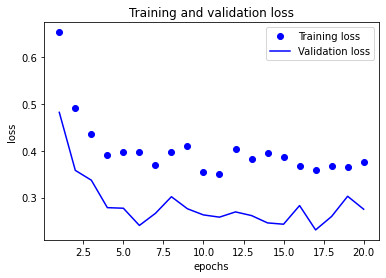

In [ ]:
# plot training and validation loss for each epoch
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, valid_loss, 'b', label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.legend(loc='upper right')
plt.show()

### Evaluate the performance of the model on the test dataset

In [ ]:
# load the model with the lowest validation loss
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>